# pythagoras

Welcome to _pythagoras_. For more information about the project, visit the [project website](http://web.simmons.edu/~bellanti/pythagoras) or the Github repo.

---


### Load libraries and settings

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lxml import etree
import re
from collections import Counter
%matplotlib inline

### Parse the MusicXML file

In [3]:
# xml_filepath = "./scores/xml/JSB_BWV1047_1.xml"
# xml_filepath = "./scores/xml/JSB_BWV1047_2.xml"
# xml_filepath = "./scores/xml/JSB_BWV1047_3.xml"
# xml_filepath = "./scores/xml/JB_op51_no1_2.xml"
# xml_filepath = "./scores/xml/JB_op51_no1_3.xml"
xml_filepath = "./scores/xml/JB_op51_no1_4.xml"

In [5]:
tree = etree.parse(xml_filepath)
root = tree.getroot()

### Get information about the work

In [6]:
print('\nINSTRUMENTATION:\n')

parts = []

for e in root.xpath('//score-part'):
    part = e.xpath('./@id')[0]
    parts.append(part)
    instr = e.xpath('.//instrument-name')[0].text
    print("\t%s (%s)" % (instr,part))


INSTRUMENTATION:

	Violin (P1)
	Violin (P2)
	Viola (P3)
	Cello (P4)


In [7]:
print('\nKEY & TIME\n')

attrib_list = root.xpath("//part[@id='P1']/measure[@number='1']/attributes/*")

key_dict = {
    '-7':'Cb major (Ab minor)',
    '-6':'Gb major (Eb minor)',
    '-5':'Db major (Bb minor)',
    '-4':'Ab major (F minor)',
    '-3':'Eb major (C minor)',
    '-2':'Bb major (G minor)',
    '-1':'F major (D minor)',
    '0':'C major (A minor)',
    '1':'G major (E minor)',
    '2':'D major (B minor)',
    '3':'A major (F# minor)',
    '4':'E major (C# minor)',
    '5':'B major (G# minor)',
    '6':'F# major (D# minor)',
    '7':'C# major (A# minor)'
}

for e in attrib_list:
    if e.tag == 'key':
        accidentals = e.xpath('./fifths')[0].text
        mode = e.xpath('./mode')[0].text
        key = key_dict[accidentals]
        print("\tKey signature:\t", key)
    if e.tag == 'time':
        beats = e.xpath('./beats')[0].text
        val = e.xpath('./beat-type')[0].text
        time = "%s/%s" % (beats,val)
        print("\tTime signature:\t",time)


KEY & TIME

	Key signature:	 Eb major (C minor)
	Time signature:	 2/2


### Build a dataframe with notes

In [8]:
notes = []

for e in root.xpath('//note'):
    
    part = e.xpath('../..//@id')[0]
    
    measure = e.xpath('..//@number')[0]
    
    dotted = True if 'dot' in [child.tag for child in e] else False

    grace = True if 'grace' in [child.tag for child in e] else False

    cue = True if 'cue' in [child.tag for child in e] else False

    rest = True if 'rest' in [child.tag for child in e] else False
    
    duration_list = e.xpath('.//duration/text()')
    duration = duration_list[0] if len(duration_list)>0 else ''
    
    typ_list = e.xpath('.//type/text()')
    typ = typ_list[0] if len(typ_list)>0 else ''

    step_list = e.xpath('.//step/text()')
    step = step_list[0] if len(step_list)>0 else ''
    
    alter_list = e.xpath('.//alter/text()')
    alter = alter_list[0] if len(alter_list)>0 else ''
    if alter == '0':
        accidental = ''
    elif alter == '-1':
        accidental = 'b'
    elif alter == '1':
        accidental = '#'
    elif alter == '-2':
        accidental = 'bb'
    elif alter == '2':
        accidental = '##'
    else:
        accidental = ''

    pitch = step + accidental
    
    octave_list = e.xpath('.//octave/text()')
    octave = octave_list[0] if len(step_list)>0 else ''
    
    notes.append((part,measure,pitch,step,alter,octave,duration,typ,dotted,rest,grace,cue))


In [9]:
df = pd.DataFrame(notes,columns=['part','measure','pitch','step','alter','octave','duration','type','dotted','rest','grace','cue'])
print(df)

     part measure pitch step alter octave duration     type  dotted   rest  \
0      P1       1     F    F            6        3  quarter    True  False   
1      P1       1     G    G            6        1   eighth   False  False   
2      P1       1     G    G            6        3  quarter    True  False   
3      P1       1    Ab    A    -1      6        1   eighth   False  False   
4      P1       2    Ab    A    -1      6        2  quarter   False  False   
5      P1       2     B    B            5        2  quarter   False  False   
6      P1       2                                2  quarter   False   True   
7      P1       2     C    C            5        2  quarter   False  False   
8      P1       3    Ab    A    -1      4        4     half   False  False   
9      P1       3     G    G            4        1   eighth   False  False   
10     P1       3     D    D            5        1   eighth   False  False   
11     P1       3     D    D            5        1   eighth   Fa

### Vizualizations

Text(0.5,1,'Note types')

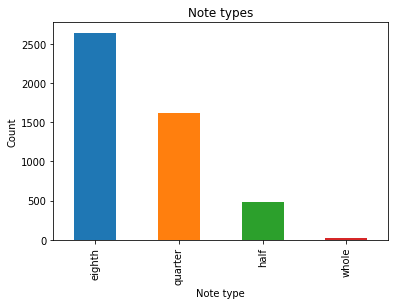

In [10]:
col = 'type'
df[df[col]!=''].groupby(col)[col].count().sort_values(ascending=False).plot.bar()
plt.ylabel('Count')
plt.xlabel('Note type')
plt.title('Note types')

In [11]:
df = df.set_index('part',append=True)

In [12]:
pitch_df = df.groupby('pitch')['pitch'].count()
print(pitch_df)
# table = pd.pivot_table(df, values='pitch', index=[part],columns=['part'], aggfunc=np.unique)
# print(table)
# pd.pivot_table(df, columns='pitch', values='step').plot(subplots=True)
# print(table)

pitch
       630
A      193
A#      15
Ab     333
B      325
B#       1
Bb     216
Bbb      4
C      622
C#      47
Cb       9
D      488
D#      23
Db      71
E      278
E#       1
Eb     293
F      471
F#      88
F##      1
G      572
G#      63
Gb      30
Name: pitch, dtype: int64



PITCH COUNTS BY PART



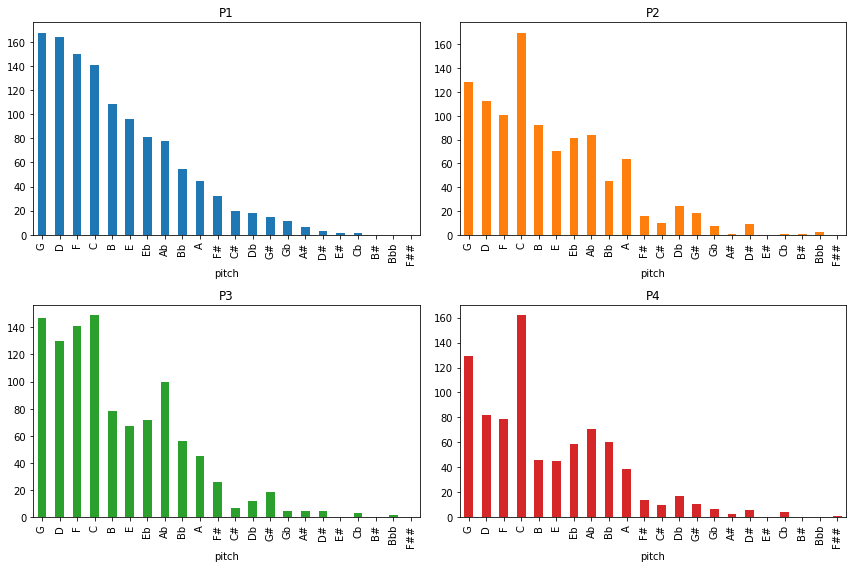

In [13]:
print('\nPITCH COUNTS BY PART\n')

col = 'pitch'
result = df[df[col]!=''].groupby(['part',col])[col].count()
result_df = result.to_frame().rename (columns={col:'count'}).reset_index()
p = len(parts)
if p%2 == 0:
    num_rows = int(p/2)
    fig, ax = plt.subplots(num_rows,2,figsize=(12,num_rows*4))
elif p%3 == 0:
    num_rows = int(p/3)
    fig, ax = plt.subplots(num_rows,3,figsize=(15,num_rows*3))
else:
    num_rows = p
    fig, ax = plt.subplots(num_rows,1,figsize=(10,num_rows))

result_df.pivot(index=col,columns='part',values='count').sort_values(by="P1",ascending=False).plot.bar(subplots=True, ax=ax,legend=False, sharex=False)

plt.tight_layout()
plt.show()




In [14]:
pitch_dict = {'A0':'1','G##0':'1','Bbb0':'1','A#0':'2','Bb0':'2','Cbb1':'2','B0':'3','Cb1':'3','A##0':'3','C1':'4','B#0':'4','Dbb1':'4','C#1':'5','Db1':'5','B##1':'5','D1':'6','C##1':'6','Dbb1':'6','D#1':'7','Eb1':'7','Fbb1':'7','E1':'8','Fb1':'8','D##1':'8','1':'8','F1':'9','E#1':'9','Gbb1':'9','F#1':'10','Gb1':'10','E##1':'10','G1':'11','F##1':'11','Abb1':'11','G#1':'12','Ab1':'12','A1':'13','G##1':'13','Bbb1':'13','A#1':'14','Bb1':'14','Cbb1':'14','B1':'15','Cb1':'15','A##1':'15','C2':'16','B#2':'16','Dbb2':'16','C#2':'17','Db2':'17','B##2':'17','D2':'18','C##2':'18','Dbb2':'18','D#2':'19','Eb2':'19','Fbb2':'19','E2':'20','Fb2':'20','D##2':'20','2':'20','F2':'21','E#2':'21','Gbb2':'21','F#2':'22','Gb2':'22','E##2':'22','G2':'23','F##2':'23','Abb2':'23','G#2':'24','Ab2':'24','A2':'25','G##2':'25','Bbb2':'25','A#2':'26','Bb2':'26','Cbb2':'26','B2':'27','Cb2':'27','A##2':'27','C3':'28','B#3':'28','Dbb3':'28','C#3':'29','Db3':'29','B##3':'29','D3':'30','C##3':'30','Dbb3':'30','D#3':'31','Eb3':'31','Fbb3':'31','E3':'32','Fb3':'32','D##3':'32','3':'32','F3':'33','E#3':'33','Gbb3':'33','F#3':'34','Gb3':'34','E##3':'34','G3':'35','F##3':'35','Abb3':'35','G#3':'36','Ab3':'36','A3':'37','G##3':'37','Bbb3':'37','A#3':'38','Bb3':'38','Cbb3':'38','B3':'39','Cb3':'39','A##3':'39','C4':'40','B#4':'40','Dbb4':'40','C#4':'41','Db4':'41','B##4':'41','D4':'42','C##4':'42','Dbb4':'42','D#4':'43','Eb4':'43','Fbb4':'43','E4':'44','Fb4':'44','D##4':'44','4':'44','F4':'45','E#4':'45','Gbb4':'45','F#4':'46','Gb4':'46','E##4':'46','G4':'47','F##4':'47','Abb4':'47','G#4':'48','Ab4':'48','A4':'49','G##4':'49','Bbb4':'49','A#4':'50','Bb4':'50','Cbb4':'50','B4':'51','Cb4':'51','A##4':'51','C5':'52','B#5':'52','Dbb5':'52','C#5':'53','Db5':'53','B##5':'53','D5':'54','C##5':'54','Dbb5':'54','D#5':'55','Eb5':'55','Fbb5':'55','E5':'56','Fb5':'56','D##5':'56','5':'56','F5':'57','E#5':'57','Gbb5':'57','F#5':'58','Gb5':'58','E##5':'58','G5':'59','F##5':'59','Abb5':'59','G#5':'60','Ab5':'60','A5':'61','G##5':'61','Bbb5':'61','A#5':'62','Bb5':'62','Cbb5':'62','B5':'63','Cb5':'63','A##5':'63','C6':'64','B#6':'64','Dbb6':'64','C#6':'65','Db6':'65','B##6':'65','D6':'66','C##6':'66','Dbb6':'66','D#6':'67','Eb6':'67','Fbb6':'67','E6':'68','Fb6':'68','D##6':'68','6':'68','F6':'69','E#6':'69','Gbb6':'69','F#6':'70','Gb6':'70','E##6':'70','G6':'71','F##6':'71','Abb6':'71','G#6':'72','Ab6':'72','A6':'73','G##6':'73','Bbb6':'73','A#6':'74','Bb6':'74','Cbb6':'74','B6':'75','Cb6':'75','A##6':'75','C7':'76','B#7':'76','Dbb7':'76','C#7':'77','Db7':'77','B##7':'77','D7':'78','C##7':'78','Dbb7':'78','D#7':'79','Eb7':'79','Fbb7':'79','E7':'80','Fb7':'80','D##7':'80','7':'80','F7':'81','E#7':'81','Gbb7':'81','F#7':'82','Gb7':'82','E##7':'82','G7':'83','F##7':'83','Abb7':'83','G#7':'84','Ab7':'84','A7':'85','G##7':'85','Bbb7':'85','A#7':'86','Bb7':'86','Cbb8':'86','B7':'87','Cb8':'87','A##7':'87','C8':'88','B#7':'88','Dbb8':'88'}

### Pitches

Because this song is written in the key of F, the expected most common pitches are as follows:

* **I chord**: F-A-C
* **IV chord**: Bb-D-F
* **V(7) chord**: C-E-G(-Bb)
* **vi chord**: D-F-A
* **ii chord**: G-Bb-D

Text(0.5,1,'Pitches')

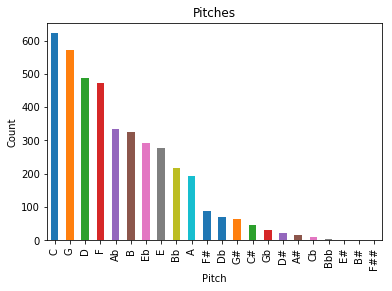

In [15]:
col = 'pitch'
df[df[col]!=''].groupby(col)[col].count().sort_values(ascending=False).plot.bar(subplots=True)
plt.ylabel('Count')
plt.xlabel('Pitch')
plt.title('Pitches')

## Match patterns
Using the string generated from the dataframe series, match any reoccuring patterns longer than a given length.

In [16]:
print(df['pitch'])
print(df.columns)

      part
0     P1       F
1     P1       G
2     P1       G
3     P1      Ab
4     P1      Ab
5     P1       B
6     P1        
7     P1       C
8     P1      Ab
9     P1       G
10    P1       D
11    P1       D
12    P1       F
13    P1       C
14    P1       B
15    P1       D
16    P1       D
17    P1       B
18    P1       B
19    P1       C
20    P1       G
21    P1       F
22    P1      Eb
23    P1      C#
24    P1       G
25    P1      F#
26    P1      C#
27    P1      C#
28    P1       D
29    P1       D
              ..
4744  P4      Ab
4745  P4      Ab
4746  P4       C
4747  P4       C
4748  P4       C
4749  P4       G
4750  P4        
4751  P4       C
4752  P4       G
4753  P4       G
4754  P4       C
4755  P4       C
4756  P4       G
4757  P4       G
4758  P4      Eb
4759  P4      Eb
4760  P4       C
4761  P4       C
4762  P4      Ab
4763  P4      Eb
4764  P4       C
4765  P4        
4766  P4       G
4767  P4        
4768  P4       G
4769  P4        
4770  P4       C
477

In [17]:
steps = df['pitch'].to_string(index=False)
steps = re.sub(r'\n|\t| ','',steps)
print(steps)

partFGGAbAbBCAbGDDFCBDDBBCGFEbC#GF#C#C#DDDC#C#DDDEEFFFEEFFFEEFFEEFFGGAbAbCCFFGGAbAbBCAbGDDFCBDDBBCF#GCGBDEbF#GCGBCBBCCBBCCDDEbEbGGBCBBCCBBCCAbAbFFDDCGF#F#GGF#F#GGBBDDF#F#GGF#F#GGF#F#GGEbEbCCAAGDGGDDDDDDGGDDDDDDGGDDGGDDGGDDGGCCAbBbGAbFGEbGEbGEbGEbDbFAbFEbGBbGDbAbFAbGEbBDGEbFDEbCDBbDBbDBbDBbBbGbAbFGbEbFDFDFDBbDDFBbBbAbGFEbGAbBbCEbEbFCEbEbFDDCBbCBbAbGbAbGbFEbFEbEbDbCDbCBbABbAbGbFGbFGbEbEbEbCFFFFFBbEbDbCBbCBbAbCbBbAbBbAbGBbEbEGCFAbEbDFBbGBbEbGBEbGCEbC#EbDDEbDCBbAbGFEbDCEbAbCEAbCFAbAbCCCGGDFBBCDbCBbAbGFFAbDbFADbFBbDbDbFFAbFGGAbAbBFFGGAbAbFFBbEEAbFDEbEFBbAbFC#DDBbEFEbDCBbBbAbGGFFFGGAbAbGAABbBbABBCCABBCABBCABBCCDDEbCDDEbEbEEFEFFGGAbAbBCAbEbCCAbGbEbAbCEbAbGbEbAbCEbAbGbEbCGbAF#D#EG#G#F#F#EEC#C#BBA#A#G#G#EG#EBG#G#EDBEG#BEDBEG#BEDDBG#EDBEEAGGFFEECCBBAAGGEA#BF#CF#BF#GGBBCGFEEFCBAFD#EBBEEAAEEBBEEAAEEBBEEBBEEBBEEBBEAFGEFDECECECECBbDFDCEGEBbFDFECBG#ECDBCABGBGBGBGGEbFDEbCDBDBDBGBBDGGFEDCEFGACCDACCDBBAGAGFEbFEbDCDCCBbABbAGF#GFEbDEbDEbCCCADDDDDGCBbAGAGFAbGFGFEGCC#EADFCBDGEGCEG#CEACA#CBBCBAGFEDCBACFAC#FA

In [18]:
min_length = 8
min_occur = 2
pat = r'(?=(.{%d,})).*\1{%d,}' % (min_length, min_occur-1)

step_patterns = re.findall(pat,steps)

print(Counter(step_patterns))

Counter({'partFGGAbAbBCAbGDDFCBDDBBCGFEbC#GF#C#C#DDDC#C#DDDEEFFFEEFFFEEFFEEFFGGAbAbCCFFGGAbAbBCAbGDDFCBDDBBCF#GCGBDEbF#GCGBCBBCCBBCCDDEbEbGGBCBBCCBBCCAbAbFFDDCGF#F#GGF#F#GGBBDDF#F#GGF#F#GGF#F#GGEbEbCCAAGDGGDDDDDDGGDDDDDDGGDDGGDDGGDDGGCCAbBbGAbFGEbGEbGEbGEbDbFAbFEbGBbGDbAbFAbGEbBDGEbFDEbCDBbDBbDBbDBbBbGbAbFGbEbFDFDFDBbDDFBbBbAbGFEbGAbBbCEbEbFCEbEbFDDCBbCBbAbGbAbGbFEbFEbEbDbCDbCBbABbAbGbFGbFGbEbEbEbCFFFFFBbEbDbCBbCBbAbCbBbAbBbAbGBbEbEGCFAbEbDFBbGBbEbGBEbGCEbC#EbDDEbDCBbAbGFEbDCEbAbCEAbCFAbAbCCCGGDFBBCDbCBbAbGFFAbDbFADbFBbDbDbFFAbFGGAbAbBFFGGAbAbFFBbEEAbFDEbEFBbAbFC#DDBbEFEbDCBbBbAbGGFFFGGAbAbGAABbBbABBCCABBCABBCABBCCDDEbCDDEbEbEEFEFFGGAbAbBCAbEbCCAbGbEbAbCEbAbGbEbAbCEbAbGbEbCGbAF#D#EG#G#F#F#EEC#C#BBA#A#G#G#EG#EBG#G#EDBEG#BEDBEG#BEDDBG#EDBEEAGGFFEECCBBAAGGEA#BF#CF#BF#GGBBCGFEEFCBAFD#EBBEEAAEEBBEEAAEEBBEEBBEEBBEEBBEAFGEFDECECECECBbDFDCEGEBbFDFECBG#ECDBCABGBGBGBGGEbFDEbCDBDBDBGBBDGGFEDCEFGACCDACCDBBAGAGFEbFEbDCDCCBbABbAGF#GFEbDEbDEbCCCADDDDDGCBbAGAGFAbGFGFEGCC#EADFCBDGEGCEG#CEACA#CBBCBAGFED

In [19]:
min_length = 5
min_occur = 8
pat = r'(?=(.{%d,})(?=.*\1){%d,})' % (min_length, min_occur-1)
step_patterns = re.findall(pat,steps)
print(Counter(step_patterns))

Counter({'AbAbAbAbAbAb': 8, 'bAbAbAbAbAb': 7, 'BbAbG': 6, 'AbAbAb': 6, 'DDEbEb': 5, 'DEbEb': 5, 'GGGGGGGG': 5, 'GGGGGGG': 5, 'GGGGGG': 5, 'GGGGG': 5, 'bBbBb': 5, 'bCCAb': 5, 'F#F#G': 5, 'bAbGG': 5, 'EbEbCC': 5, 'EbCEb': 5, 'bAbAb': 5, 'GAbAb': 5, 'bCEbEb': 4, 'EbEbC': 4, 'AbAbFF': 4, 'bAbFF': 4, 'FFGGAbAb': 4, 'FGGAbAb': 4, 'AbAbG': 4, 'CDDEbEb': 4, 'AbAbBC': 4, 'bAbBC': 4, 'GFEbD': 4, 'EbCCC': 4, 'FFEEFF': 4, 'FEEFF': 4, 'CCAbAb': 4, 'CAbAb': 4, 'BbBbBb': 4, 'bEbCCAb': 4, 'EbCCAb': 4, 'CEbEb': 4, 'AbAbGG': 4, 'FBbBb': 4, 'CEbEbC': 4, 'bEbCC': 4, 'DbDbCC': 4, 'bDbCC': 4, 'AbCFAb': 4, 'bCFAb': 4, 'EbEbD': 4, 'AbGGFF': 4, 'bGGFF': 4, 'G#G#E': 4, 'BbBbD': 4, 'CCCCC': 4, 'AbAbC': 4, '#F#F#': 4, 'GGAbAb': 4, 'CBBCC': 3, 'EbEbGG': 3, 'bEbGG': 3, 'F#F#GG': 3, '#F#GG': 3, 'DDGGDDGGD': 3, 'DGGDDGGD': 3, 'EbGEbG': 3, 'AbFEb': 3, 'AbFAb': 3, 'AbGEb': 3, 'BbDBb': 3, 'bBbAbG': 3, 'EbEbF': 3, 'CBbAbG': 3, 'bAbGb': 3, 'FFFFF': 3, 'FEbDC': 3, 'bCCCG': 3, 'FGGAbAbB': 3, 'GGAbAbB': 3, 'GAbAbB': 3, 'AbAb